In [167]:
# IMPORTS

%pylab inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from smile.log import log2dl
from smile.log import log2csv

from datetime import datetime
from dateutil import tz


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [168]:
# ENTER SLOG INFO HERE

slogDirs = ['subj001_JoR/', 'subj002_JoR/', 'subj003_JoR/']
slogName = 'log_JoR_0.slog'

In [169]:
# SEABORN SETTINGS

sns.set_style(style='darkgrid')
sns.set(font_scale=2)
figsize=[16, 4]

In [170]:
# Create dataframes from slogs

dataframes = []
for slogDir in slogDirs:
    df = pd.DataFrame(log2dl(slogDir + slogName))  # Makes the slog into a dataframe
    dataframes.append(df)
    
dataframes[0].head()  # Show the first 5 records of the dataframe

,base,block,correct,date1,date2,img1,img2,log_num,log_time,oddGapClass,...,press_error,press_time,pulse_off_error,pulse_off_time,pulse_on_error,pulse_on_time,resp,rt,trial_absolute,trial_inBlock
0,262275.575896,1,True,20170620,20170619,images/subj001_day9/morning/https_--userhome-a...,images/subj001_day8/morning/https_--userhome-a...,0,262278.337646,False,...,0.000206,262278.337646,0.000013,262263.838725,0.000011,262263.828593,J,2.761749,1,1
1,262290.109061,1,True,20170626,20170629,images/subj001_day15/morning/https_--userhome-...,images/subj001_day18/morning/https_--userhome-...,0,262290.819062,False,...,0.000199,262290.819062,0.000012,262278.360075,0.000009,262278.341228,J,0.710001,2,2
2,262301.408929,1,False,20170701,20170701,images/subj001_day20/afternoon/https_--userhom...,images/subj001_day20/morning/https_--userhome-...,0,262302.644405,False,...,0.000198,262302.644405,0.000011,262290.843253,0.000009,262290.822484,F,1.235476,3,3
3,262313.108786,1,False,20170702,20170701,images/subj001_day21/afternoon/https_--userhom...,images/subj001_day20/morning/https_--userhome-...,0,262316.104073,False,...,NaN,NaN,0.000013,262302.659757,0.000009,262302.647854,,NaN,4,4
4,262326.325297,1,False,20170618,20170615,images/subj001_day7/afternoon/https_--userhome...,images/subj001_day4/morning/https_--userhome-a...,0,262326.919632,False,...,0.000199,262326.919632,0.000012,262316.126242,0.000009,262316.106999,F,0.594335,5,5


# Basic characterization

Let's first look at the responses themselves, and how they relate to RTs.

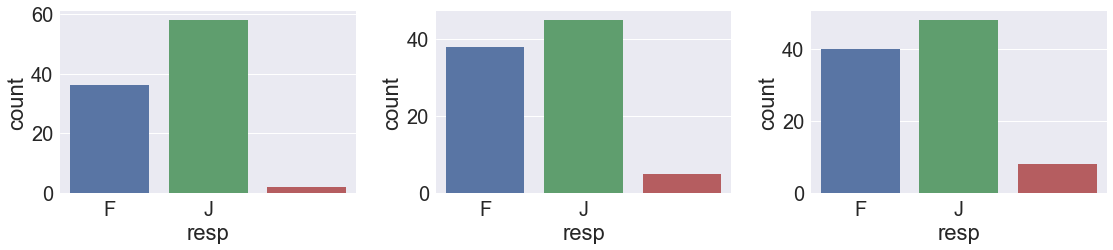

In [171]:
fig, axs = plt.subplots(ncols=len(slogDirs), figsize=figsize)

for i in range(len(slogDirs)):
    plot = sns.countplot(data=dataframes[i], x='resp', order=['F', 'J', ''], ax=axs[i])
    
fig.tight_layout()

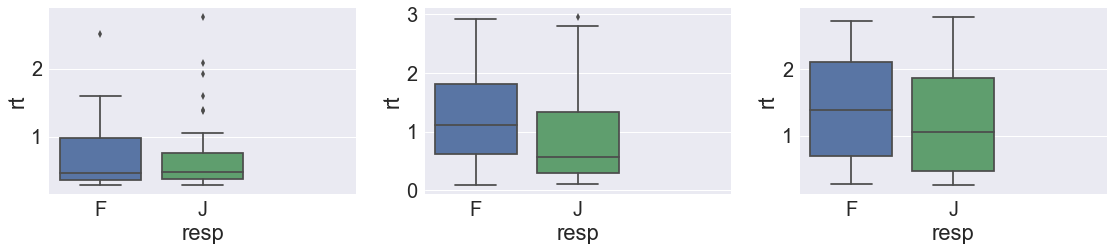

In [172]:
fig, axs = plt.subplots(ncols=len(slogDirs), figsize=figsize)

for i in range(len(slogDirs)):
    plot = sns.boxplot(data=dataframes[i], x='resp', y='rt', order=['F', 'J', ''], ax=axs[i])
    
fig.tight_layout()

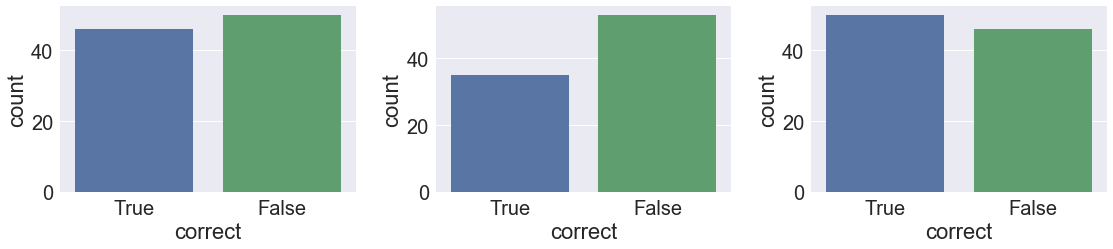

In [173]:
fig, axs = plt.subplots(ncols=len(slogDirs), figsize=figsize)

for i in range(len(slogDirs)):
    plot = sns.countplot(data=dataframes[i], x='correct', order=[True, False], ax=axs[i])
    
fig.tight_layout()

# Session time

Now let's see if reaction time changes over the length of the session.

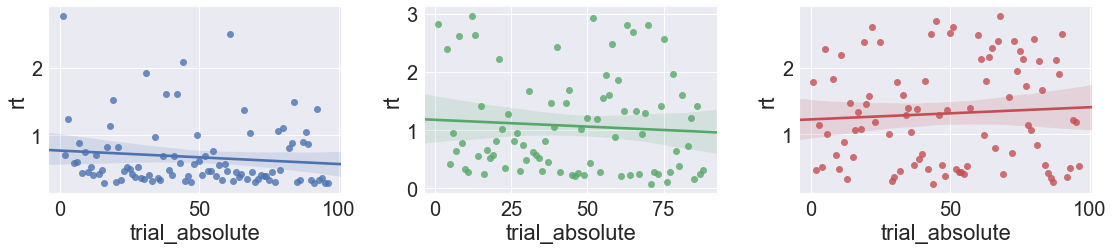

In [174]:
fig, axs = plt.subplots(ncols=len(slogDirs), figsize=figsize)

for i in range(len(slogDirs)):
    plot = sns.regplot(data=dataframes[i], x='trial_absolute', y='rt', ax=axs[i])
    
fig.tight_layout()

# Timescale characterization

What was the distribution of pairs across timescales?

In [175]:
for i in range(len(slogDirs)):
    df = dataframes[i]
    # Add a column representing the time-gaps, in whole days, between the images,
    # and another column representing the coarser categories we used in listgen.
    dayGaps = []
    gapClasses = []

    for i in range(len(df['trial_absolute'])):
        
        img1 = df['img1'][i]
        img2 = df['img2'][i]
        datetime1 = img1[img1.index('Z')-14:img1.index('Z')]
        datetime2 = img2[img2.index('Z')-14:img2.index('Z')]
        
        # Timezones:
        from_zone = tz.gettz('UTC')
        to_zone = tz.gettz('America/New_York')

        # utc = datetime.utcnow()
        utc1 = datetime.strptime(datetime1, '%Y%m%d%H%M%S')
        utc2 = datetime.strptime(datetime2, '%Y%m%d%H%M%S')

        # Tell the datetime object that it's in UTC time zone since 
        # datetime objects are 'naive' by default
        utc1 = utc1.replace(tzinfo=from_zone)
        utc2 = utc2.replace(tzinfo=from_zone)

        # Convert time zone
        eastern1 = utc1.astimezone(to_zone)
        eastern2 = utc2.astimezone(to_zone)
    
        gap = abs(eastern1 - eastern2).days
        dayGaps.append(gap)

        if gap == 0:
            gapClass = '0'
        elif gap in range(1, 3):
            gapClass = '1to2'
        elif gap in range(4, 7):
            gapClass = '4to6'
        elif gap in range(8, 13):
            gapClass = '8to12'
        elif gap == 7:
            gapClass = '7'
        else:
            gapClass = 'other'
        gapClasses.append(gapClass)

    df['gap'] = pd.Series(dayGaps, index=df.index)
    df['gapClass'] = pd.Series(gapClasses, index=df.index)
    df.head()

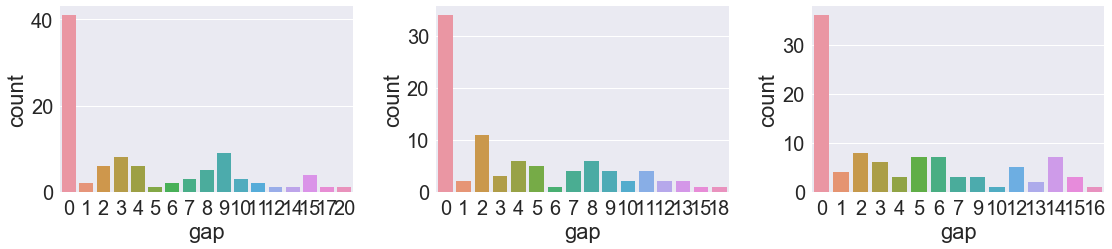

In [176]:
fig, axs = plt.subplots(ncols=len(slogDirs), figsize=figsize)

for i in range(len(slogDirs)):
    plot = sns.countplot(data=dataframes[i], x='gap', ax=axs[i])
    
fig.tight_layout()

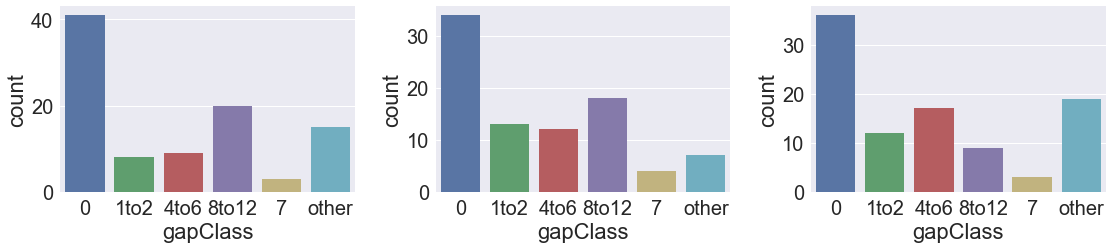

In [177]:
fig, axs = plt.subplots(ncols=len(slogDirs), figsize=figsize)

for i in range(len(slogDirs)):
    plot = sns.countplot(data=dataframes[i], x='gapClass', order=['0', '1to2', '4to6', '8to12', '7', 'other'], ax=axs[i])
    
fig.tight_layout()

# Timescale versus memory

Do longer timescales correspond to worse recall?

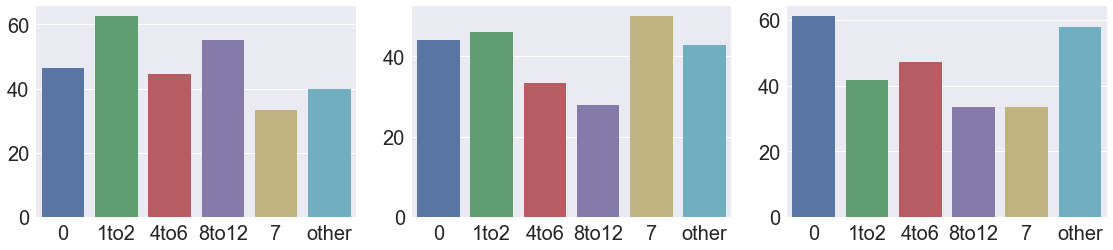

In [178]:
gapClassNames = ['0', '1to2', '4to6', '8to12', '7', 'other']


fig, axs = plt.subplots(ncols=len(slogDirs), figsize=figsize)

for i in range(len(slogDirs)):
    df = dataframes[i]
    
    correctPercents_byGapClass = {}

    for gapClassName in gapClassNames:
        correctNumber = ((df['correct'] == True) & (df['gapClass'] == gapClassName)).sum()
        totalNumber = (df['gapClass'] == gapClassName).sum()
        correctPercent = 100*float(correctNumber)/float(totalNumber)
        correctPercents_byGapClass.update({gapClassName: correctPercent})

    correctPercentsList = []
    for key in gapClassNames:
        correctPercentsList.append(correctPercents_byGapClass[key])

    plot = sns.barplot(x=gapClassNames, y=correctPercentsList, ax=axs[i])
    
fig.tight_layout()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>




# Loose code below:

In [ ]:
sns.set_style(style='darkgrid')
sns.set(font_scale=2)

def r2(x, y):
    return scipy.stats.pearsonr(x, y)[0] ** 2

plot = sns.jointplot(data=df,
                      x='compositeMetric',
                      y='avg_score_across_all_trials',
                      size=7, kind='reg')
plot.set_axis_labels('AUDIT/BIS-11/GABS composite score', 'Earlyness/lateness')




#df.to_csv('spreadsheet.csv')

#df.head()  # Show the first 5 records of the dataframe

#df['trial_num_block'][0:32]  # Show records x to y of the dataframe (remember these are indices, so they start at 0)

#df['column'][x]  # Show xth record's entry in the specific field "column"

#df.to_csv('spreadsheetname.csv')  # Save out the dataframe as a csv spreadhseet

#df2 = pd.read('spreadsheetname.csv')  # Read a csv spreadsheet back into a dataframe